# __Springboard Data Science Capstone 3 Project__
# _Predicting the Price of Energy_

### Pre-Processing & Modeling

##### _Ben Takacs_
###### __Python version 3.10.4__

### __Imports and File Location__

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from functions import load_csv_data, arima_mse, model_eval, sarima_mse

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose


### __Load Data__

In [45]:
df = pd.read_csv('./data/df1.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df

,"Average Price of Electricity to Ultimate Customers, Residential",Total Renewable Energy Consumption,Total Petroleum Consumed by the Residential Sector,Natural Gas Consumed by the Electric Power Sector,"Natural Gas Consumed by the Transportation Sector, Vehicle Fuel"
Month,,,,,
1990-02-01,7.48,0.321465,143.972,153.181,0.021
1990-03-01,7.57,0.353956,129.117,214.167,0.023
1990-04-01,7.69,0.334136,108.024,231.641,0.022
1990-05-01,7.96,0.317791,94.930,283.776,0.023
1990-06-01,8.10,0.289276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,0.758321,53.691,1045.631,4.514
2024-06-01,16.42,0.742351,40.900,1243.853,4.368
2024-07-01,16.63,0.733689,31.619,1534.444,4.514


Average price is in units of cents per kilowatt hour, including taxes.\
Renewable energy consumption is in units of quadrillion Btu (10^15)\
Petroleum consumption is in units of trillion Btu (10^12)\
Natural gas consumed is in units of billion cubic feet (10^12)\
Need to convert  energies to same unit.
Also going to rename columsn to something easier.

In [46]:
df.rename(columns={'Average Price of Electricity to Ultimate Customers, Residential':'Price', 'Total Renewable Energy Consumption':'Renewable', 'Total Petroleum Consumed by the Residential Sector':'Petroleum', 'Natural Gas Consumed by the Electric Power Sector':'Electric', 'Natural Gas Consumed by the Transportation Sector, Vehicle Fuel':'Transportation'}, inplace=True)
df.Renewable *= 1e3
df

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,7.48,321.465,143.972,153.181,0.021
1990-03-01,7.57,353.956,129.117,214.167,0.023
1990-04-01,7.69,334.136,108.024,231.641,0.022
1990-05-01,7.96,317.791,94.930,283.776,0.023
1990-06-01,8.10,289.276,87.671,345.768,0.022
...,...,...,...,...,...
2024-05-01,16.43,758.321,53.691,1045.631,4.514
2024-06-01,16.42,742.351,40.900,1243.853,4.368
2024-07-01,16.63,733.689,31.619,1534.444,4.514


Renewable and Petroleum now have same units (trillion Btu)

In [47]:
exog = pd.read_csv('./data/exog.csv', index_col=0)
exog.set_index(pd.to_datetime(exog.index), inplace=True)
exog

,Population,GDP
Month,,
1990-02-01,252.273689,10058.925806
1990-03-01,252.500884,10087.247931
1990-04-01,252.728323,10115.630336
1990-05-01,252.956003,10144.072517
1990-06-01,253.183924,10172.573960
...,...,...
2024-05-01,335.258213,23340.273105
2024-06-01,335.309775,23404.211001
2024-07-01,335.359756,23468.810867


##### Don't need to scale data because it's a time series

### __Test Train Split__

In [48]:
# Make differenced dataframe as well for use with modeling
df_diff = pd.DataFrame()
for col in df.columns:
    df_diff[col] = np.diff(df[col])

df_diff.index = df.index[:-1]
df_diff.dropna(inplace=True)
df_diff

,Price,Renewable,Petroleum,Electric,Transportation
Month,,,,,
1990-02-01,0.09,32.491,-14.855,60.986,0.002
1990-03-01,0.12,-19.820,-21.093,17.474,-0.001
1990-04-01,0.27,-16.345,-13.094,52.135,0.001
1990-05-01,0.14,-28.515,-7.259,61.992,-0.001
1990-06-01,0.08,26.596,-2.301,33.816,0.001
...,...,...,...,...,...
2024-04-01,-0.45,21.792,-17.515,163.693,0.146
2024-05-01,-0.01,-15.970,-12.791,198.222,-0.146
2024-06-01,0.21,-8.662,-9.281,290.591,0.146


In [49]:
split = 0.8

#Endogenous vars
# normal
train, test = train_test_split(df, train_size=split, shuffle=False)
ytrain = train.Price; ytest = test.Price
xtrain = train.drop(columns='Price'); xtest = test.drop(columns='Price')

# differenced
train_diff, test_diff = train_test_split(df_diff, train_size=split, shuffle=False)
ytrain_diff = train_diff.Price; ytest_diff = test_diff.Price
xtrain_diff = train_diff.drop(columns='Price')
xtest_diff = test_diff.drop(columns='Price')

# Exogenous vars
extrain, extest = train_test_split(exog, train_size=split, shuffle=False)

In [50]:
print(train.shape, test.shape)
print(extrain.shape, extest.shape)
print(train_diff.shape, test_diff.shape)

(332, 5) (84, 5)
(332, 2) (84, 2)
(332, 5) (83, 5)


### __ARIMA Modeling__

Only takes one variable, price. 

### Eyeball Analysis

From our ACF and PACF analysis in the EDA section, we guessed a good model would be ARIMA of order (1,1,1) or (1,1,2).

In [51]:
model_price_1 = ARIMA(ytrain_diff, order=(1,1,1))
model_price_1_fit = model_price_1.fit()
print(model_price_1_fit.summary())

model_price_2 = ARIMA(ytrain_diff, order=(1,1,2))
model_price_2_fit = model_price_2.fit()
print(model_price_2_fit.summary())

aic_delta = model_price_2_fit.aic - model_price_1_fit.aic
print(aic_delta)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  20.653
Date:                Sat, 15 Mar 2025   AIC                            -35.305
Time:                        00:03:13   BIC                            -23.899
Sample:                    02-01-1990   HQIC                           -30.756
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0863      0.149     -0.579      0.563      -0.378       0.206
ma.L1         -0.2413      0.158     -1.525      0.127      -0.552       0.069
sigma2         0.0517      0.004     13.573      0.0

Model of order (1,1,1) has lower AIC.

### Now we can search a range of orders to find the best fit (here lowest AIC, next on MSE as well)

In [52]:
# Range of pdq values to test
p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

import warnings
warnings.filterwarnings('ignore')

aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(ytrain_diff, order=(i, j, k))
                model_fit = model.fit()
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)

# import warnings
# warnings.filterwarnings("ignore")
# best_order_price = model_eval(np.diff(ytrain), p, d, q)


Best Order: (2, 0, 2)


d = 0 means data was not differenced (because we already differenced it)

In [53]:
# best_price_mse = model_eval(ytrain_diff, p, d, q)

MSE chose same model

In [57]:
forecast_length = 36 # forecast 3 years

model_arima1 = ARIMA(ytrain, order=(2,1,2), )
model_arima_fit1 = model_arima1.fit()
forecast_arima1 = model_arima_fit1.forecast(steps=forecast_length)
# .cumsum() + ytrain[-1]
# forecast_arima1 = forecast_arima1.cumsum() + ytrain_diff[-1]
model_arima_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  332
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 161.515
Date:                Sat, 15 Mar 2025   AIC                           -313.030
Time:                        00:09:08   BIC                           -294.019
Sample:                    02-01-1990   HQIC                          -305.447
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7299      0.004    387.538      0.000       1.721       1.739
ar.L2         -0.9957      0.004   -223.094      0.000      -1.004      -0.987
ma.L1         -1.7289      0.019    -91.989      0.000      -1.766      -1.692
ma.L2          0.9480      0.018     51.330      0.000       0.912       0.984
sigma2         0.0217      0.002     13.904      0.000       0.019       0.025
===================================================================================
Ljung-Box (L1) (Q):                   6.51   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.01   Prob(JB):                         0.13
Heteroskedasticity (H):               2.78   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
print(train.index[0], test.index[30])

1990-02-01 00:00:00 2020-04-01 00:00:00


MAE: 0.166
MSE: 0.046


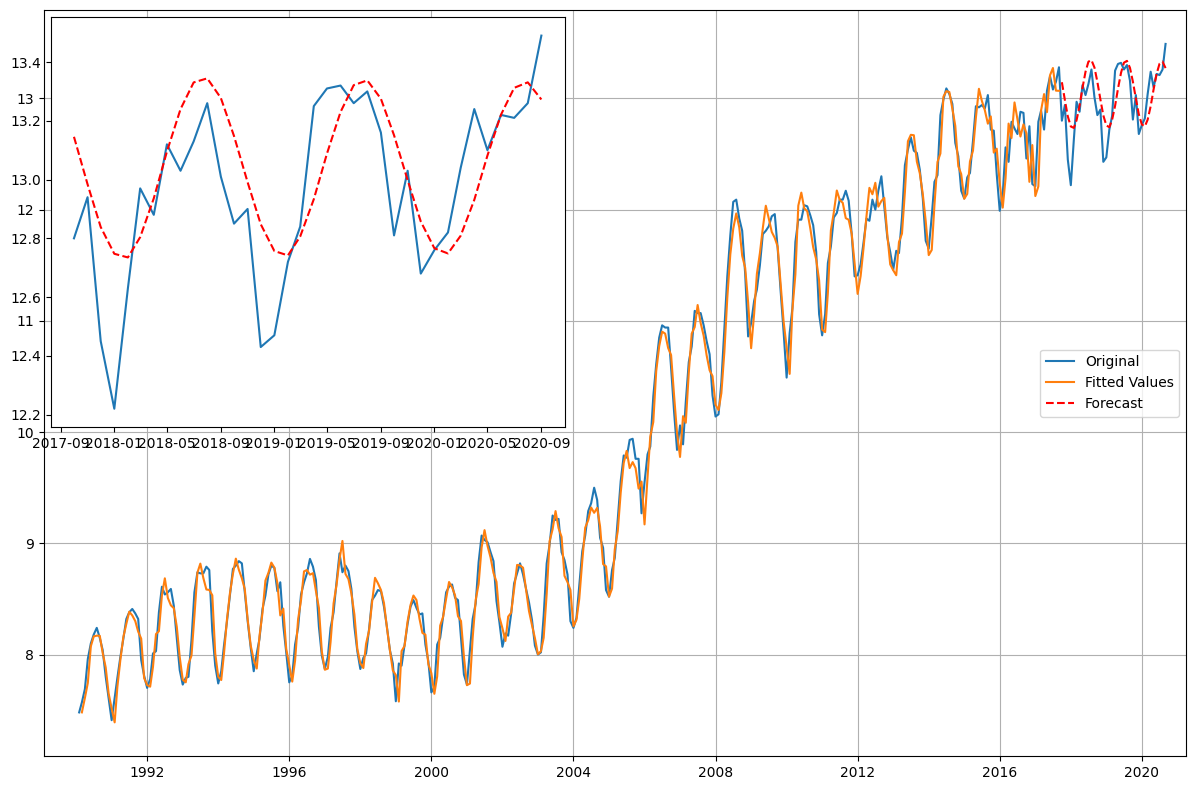

In [118]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], forecast_arima1),
    mean_squared_error(ytest[:forecast_length], forecast_arima1)
))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# plt.figure(figsize=(12,8))
fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(pd.concat([ytrain, ytest[:forecast_length]]), label='Original')
ax.plot(model_arima_fit1.fittedvalues[1:], label='Fitted Values')
ax.plot(forecast_arima1, c='r', ls='--', label='Forecast')
ax.grid(True)
ax.legend(loc='right')
ax.set_xlim(datetime.date(1989,2,1), datetime.date(2021,4,1))
# ins = ax.inset_axes([0, 0.5, 0.2,0.2])
inset = inset_axes(ax, width="45%", height="55%", loc=2)
inset.plot(ytest[:forecast_length])
inset.plot(forecast_arima1, c='r', ls='--')
plt.tight_layout()
plt.show()

Model does not perform very well, fitted values are off as well as predicted values, MAE is 0.4.

### __SARIMAX Model__

SARIMAX can take exogenous variables as well as y.

In [ ]:
model_sarima1 = SARIMAX(ytrain, exog=xtrain, order=(2, 1, 2))
model_sarima_fit1 = model_sarima1.fit(disp=False)
print(model_sarima_fit1.summary())

pred_sarima1 = model_sarima_fit1.forecast(
    steps=forecast_length, exog=xtest[:forecast_length]
)

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  332
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  70.743
Date:                Sat, 15 Mar 2025   AIC                           -127.486
Time:                        01:14:19   BIC                           -100.872
Sample:                    02-01-1990   HQIC                          -116.871
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population    -0.0320      0.201     -0.159      0.874      -0.426       0.362
GDP            0.0008      0.002      0.515      0.606      -0.002       0.004
ar.L1          1.3437      0.123     10.901      0.0

MAE: 0.509
MSE: 0.334


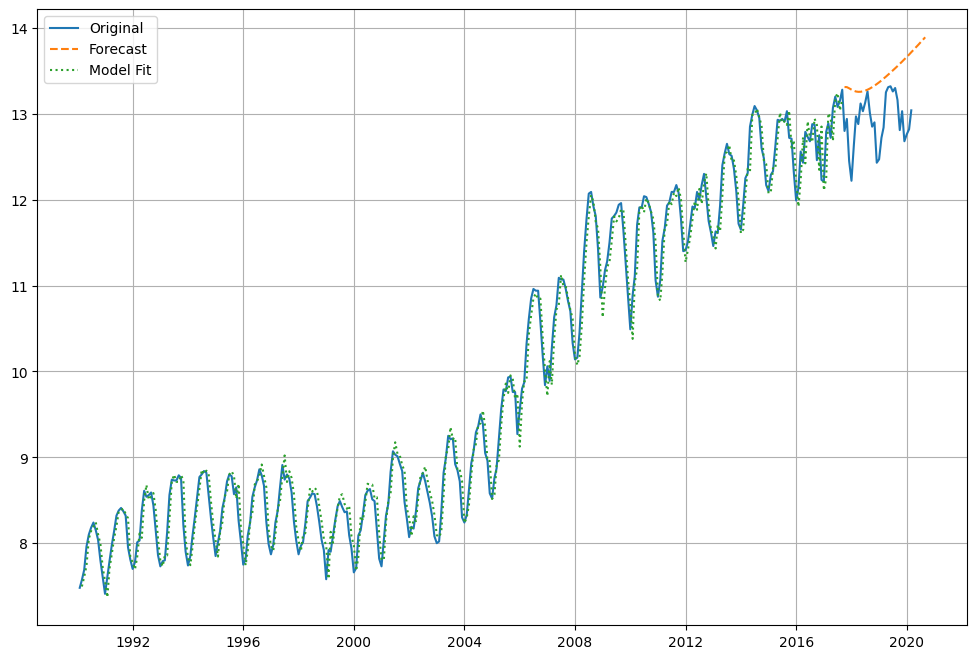

In [122]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima1),
    mean_squared_error(ytest[:forecast_length], pred_sarima1)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='Original')
# plt.plot(pred_sarima1.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(pred_sarima1, label='Forecast', ls='--')
plt.plot(model_sarima_fit1.fittedvalues[1:], label='Model Fit', ls=':')
plt.grid(True)
plt.legend()
plt.show()

Fitted values are great, prediction is very off.

In [40]:
# Using AIC, find best model order
aic_test = np.inf
for i in p:
    for j in d:
        for k in q:
            try:
                model = SARIMAX(
                    ytrain, exog=extrain, order=(i, j, k),
                )
                model_fit = model.fit(disp=False)
                if model_fit.aic < aic_test:
                    aic_test = model_fit.aic
                    best_order_price = (i, j, k)
            except:
                continue

print('\nBest Order:', best_order_price)


Best Order: (2, 1, 2)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  270
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 173.053
Date:                Fri, 14 Mar 2025   AIC                           -328.106
Time:                        23:39:51   BIC                           -295.753
Sample:                    02-01-1990   HQIC                          -315.113
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Renewable          0.0006      0.000      1.411      0.158      -0.000       0.001
Petroleum         -0.0073      0.000    -24.865      0.000      -0.008      -0.007
Electric           0.0003   9.51e-05

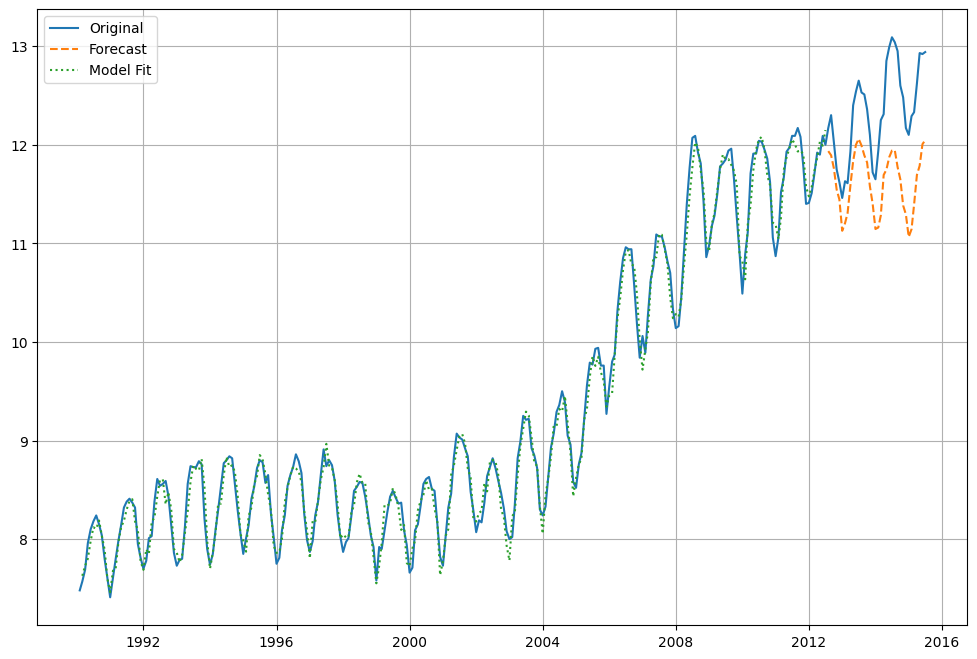

In [41]:
# SARIMAX model using endogenous variables in place of exogenous 
model_sarima2 = SARIMAX(ytrain, exog=xtrain, order=(best_order_price))
model_sarima2_fit = model_sarima2.fit(disp=False)
print(model_sarima2_fit.summary())

# Forecast using X_test
years = 3 # number of years to forecast
pred_sarima2 = model_sarima2_fit.forecast(steps=years*12, exog=xtest[:years*12])

print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:forecast_length], pred_sarima2),
    mean_squared_error(ytest[:forecast_length], pred_sarima2)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:years*12]]), label='Original')
# plt.plot(predictions.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(pred_sarima2, label='Forecast', ls='--')
plt.plot(model_sarima2_fit.fittedvalues[1:], label='Model Fit', ls=':')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
# Use only GDP as exog
model_sarimagdp = SARIMAX(ytrain, exog=extrain.GDP, order=(2, 1, 2))
model_sarimagdp_fit = model_sarimagdp.fit(disp=False)
print(model_sarimagdp_fit.summary())

# Forecast using X_test
pred_sarimagdp = model_sarimagdp_fit.forecast(steps=30, exog=extest.GDP[:30])

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  270
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 140.234
Date:                Fri, 14 Mar 2025   AIC                           -268.467
Time:                        16:50:00   BIC                           -246.899
Sample:                    02-01-1990   HQIC                          -259.805
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GDP            0.0005      0.000      2.854      0.004       0.000       0.001
ar.L1          1.7121      0.020     83.603      0.000       1.672       1.752
ar.L2         -0.9622      0.020    -49.021      0.0

MAE: 0.324
MSE: 0.164


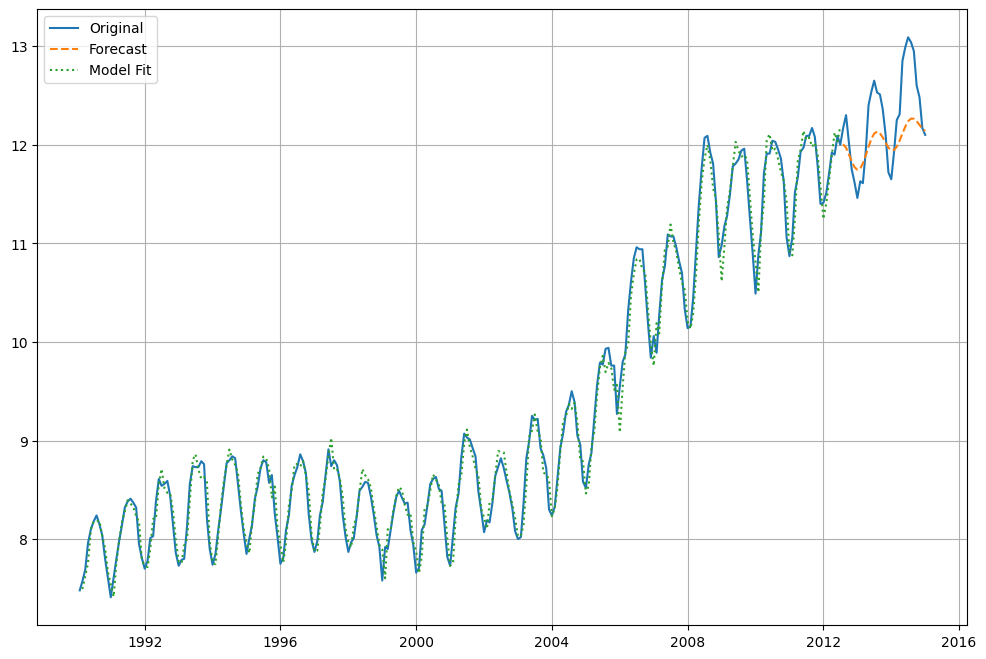

In [123]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:30], pred_sarimagdp),
    mean_squared_error(ytest[:30], pred_sarimagdp)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='Original')
# plt.plot(predictions.cumsum()+ytrain[-1], label='Forecast', ls='--')
plt.plot(pred_sarimagdp, label='Forecast', ls='--')
plt.plot(model_sarimagdp_fit.fittedvalues[1:], label='Model Fit', ls=':')
plt.grid(True)
plt.legend()
plt.show()

Best I've gotten so far by including exogenous vars. 

### __VAR Model__

In [124]:
import statsmodels.tsa.stattools as tools
select_order = tools.arma_order_select_ic(y=ytrain_diff, max_ar=4, max_ma=4)
select_order

{'bic':             0           1           2           3           4
 0  -36.160743  -95.182068 -117.174787 -123.437199 -112.558111
 1 -118.954828 -113.361806  -95.618300 -125.024890 -139.220698
 2 -113.363560 -108.743916 -281.485956 -275.937632 -259.647915
 3 -128.685144 -199.904867 -276.171989 -269.853549 -265.616216
 4 -159.150199 -211.307604 -199.155464 -264.382130 -262.899230,
 'bic_min_order': (2, 2)}

In [125]:
model_var = VAR(endog=train, exog=extrain)
model_var_fit = model_var.fit(maxlags=2, ic='bic', )
# model_var_fit = model_var.fit()
# print(model_var_fit.summary())
forecast_var = model_var_fit.forecast(y=train.values[-model_var_fit.k_ar:], steps=30, exog_future=extest[:30])

forecast_var = pd.DataFrame(forecast_var)
forecast_var.columns = train.columns
forecast_var.index = test.index[:len(forecast_var)]

This model sees much less correlation between Price and the other features, perhaps due to differencing.

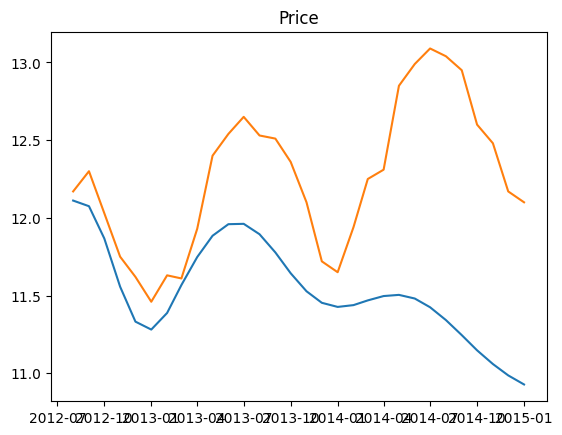

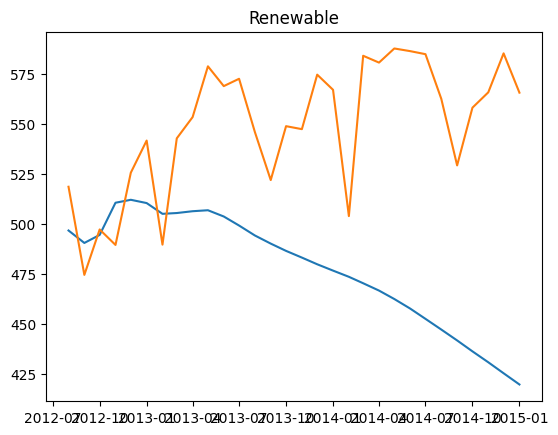

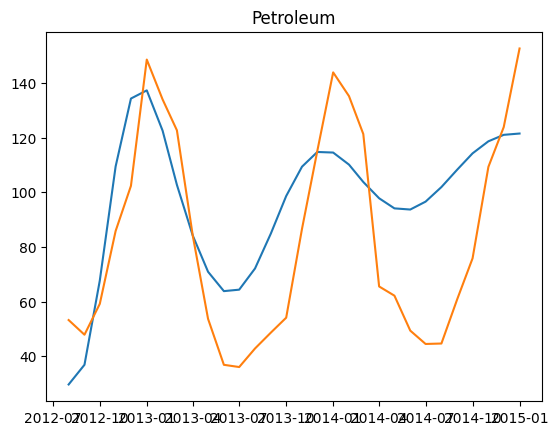

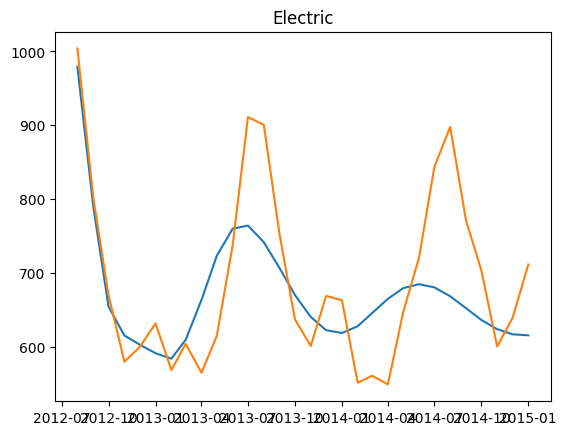

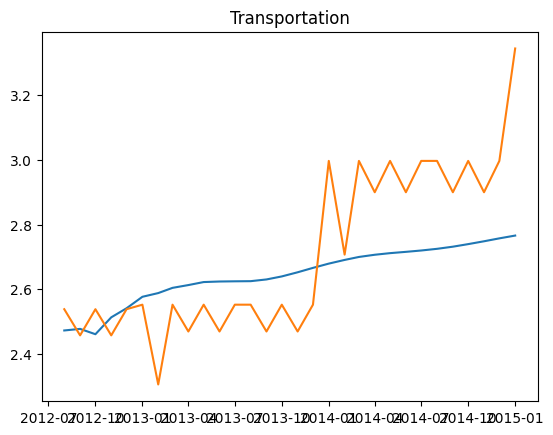

In [126]:
for col in forecast_var:
    plt.figure()
    plt.title(col)
    plt.plot(forecast_var[col], label='Prediction')
    plt.plot(test[col][:len(forecast_var)])
    plt.show()

MAE: 0.725
MSE: 0.813


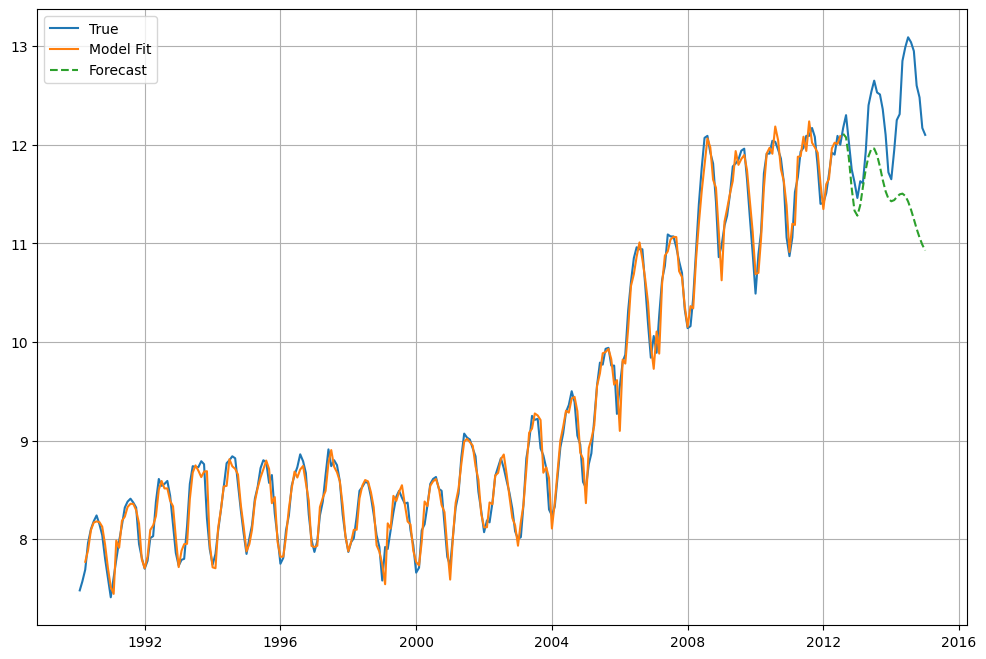

In [127]:
print('MAE: {:.3f}\nMSE: {:.3f}'.format(
    mean_absolute_error(ytest[:30], forecast_var.Price),
    mean_squared_error(ytest[:30], forecast_var.Price)
))

plt.figure(figsize=(12, 8))
plt.plot(pd.concat([ytrain, ytest[:30]]), label='True')
plt.plot(model_var_fit.fittedvalues.Price, label='Model Fit')
plt.plot(forecast_var.Price, label='Forecast', ls='--')
plt.grid(True)
plt.legend()
plt.show()

This model is not forecasting accurately, could be a problem with how the model is set up or the features we chose are not good indicators of price performance.

Future plans: Separate training and testing data using time series split.\
Modeling: ARIMA, SARIMA, FB Prophet, exponential smoothing
 RNN, XGBoost\
Employ 1 step ahead cross validation